In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

import tensorflow as tf

import pickle
import os, sys, time
import shap

In [2]:
All = pd.ExcelFile('allData.xls')
data = pd.read_excel(All, 'Data')
Excess_col_indices = list(range(0, 4)) + list(range(20, 27)) + [33]
semi_df = data.iloc[:, [col for col in range(data.shape[1]) if col not in Excess_col_indices]]
filtered_row = semi_df[semi_df['Average 28-day compressive strength (Mpa)'] > 400]
value_to_divide = filtered_row['Average 28-day compressive strength (Mpa)'].values[0]
updated_value = value_to_divide / 10
semi_df.loc[semi_df['Average 28-day compressive strength (Mpa)'] > 400, 'Average 28-day compressive strength (Mpa)'] = updated_value


In [3]:
conversion_factors = {
    '150*150*150': 1.0,
    '200h*100r': {
        (15, 44): 1.21,
        (45, 54): 1.17,
        (55, 64): 1.12,
        (65, 74): 1.10,
        (75, 84): 1.08,
        (85, 94): 1.06,
        (95, 104): 1.04,  # Guess, out of range
        (105, 114): 1.02,
    },
    '100*100*100': 0.95,
    '100*100*300': {},  # No suitable conversion index available
    '300h*150r': {
        (15, 44): 1.32,
        (45, 54): 1.32,
        (55, 64): 1.28,
        (65, 74): 1.25,
        (75, 84): 1.22,
        (85, 94): 1.19,
        (95, 104): 1.16,
        (105, 114): 1.13,
    },
    '100h*100r': {},  # No suitable conversion index available
}

def convert_strength(row):
    size = row['Specimen size']
    strength = row['Average 28-day compressive strength (Mpa)']

    original_size = size  # Store the original size

    if size in conversion_factors:
        factor = conversion_factors[size]

        if isinstance(factor, dict):
            for range_, conversion_factor in factor.items():
                lower_bound, upper_bound = range_
                if lower_bound <= strength < upper_bound:
                    return strength * conversion_factor
        else:
            return strength * factor

    return strength


# Apply the conversion function to the DataFrame
semi_df['Converted Strength'] = semi_df.apply(convert_strength, axis=1)
semi_df = semi_df.drop(['Average 28-day compressive strength (Mpa)', 'Specimen size'], axis = 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
semi_df = semi_df.dropna(subset = ['Curing method'])
new_df = pd.concat([semi_df, pd.get_dummies(semi_df['Curing method'])], axis=1)
new_df= new_df.drop(['Curing method'], axis=1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1987
Data columns (total 24 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 1   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 2   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 3   Class C Fly ash content (kg/m^3)                       1980 non-null   float64
 4   Class F Fly ash content (kg/m^3)                       1980 non-null   float64
 5   Slag content (kg/m^3)                                  1980 non-null   float64
 6   Silica fume content (kg/m^3)                           1980 non-null   float64
 7   Water content (kg/m^3)                                 1980 non-null   float64
 8   Superplasticizer content (kg/m^3)               

In [5]:
targets = new_df.iloc[:, 15:20]
features = new_df.iloc[:, list(range(0,15)) + list(range(20,24))]

In [6]:
features

,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),Maximum coarse aggregate size (mm),Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing temperature (Celsius degree),Curing humidity (%),Curing day,Air,Moist,Sealed,Submerged
0,0.0,0.0,450.0,0.0,0.0,0.0,0.0,180.0,4.00,20.0,990.0,800.0,20.0,100.0,3.0,0,0,0,1
1,0.0,0.0,400.0,0.0,0.0,0.0,0.0,200.0,3.25,20.0,990.0,877.0,20.0,100.0,3.0,0,0,0,1
2,0.0,0.0,350.0,0.0,0.0,0.0,0.0,210.0,0.00,20.0,1015.0,869.0,20.0,100.0,3.0,0,0,0,1
3,0.0,0.0,300.0,0.0,0.0,0.0,0.0,225.0,0.00,20.0,1050.0,810.0,20.0,100.0,3.0,0,0,0,1
4,0.0,0.0,315.0,0.0,135.0,0.0,0.0,180.0,1.75,20.0,990.0,800.0,20.0,100.0,3.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,350.0,0.0,0.0,0.0,0.0,0.0,50.0,180.0,2.00,20.0,983.0,806.0,21.0,100.0,28.0,0,0,0,1
1984,380.0,0.0,0.0,0.0,0.0,0.0,20.0,200.0,0.80,20.0,991.0,793.0,21.0,100.0,28.0,0,0,0,1
1985,370.0,0.0,0.0,0.0,0.0,0.0,30.0,200.0,1.20,20.0,959.0,784.0,21.0,100.0,28.0,0,0,0,1
1986,360.0,0.0,0.0,0.0,0.0,0.0,40.0,200.0,1.80,20.0,1020.0,820.0,21.0,100.0,28.0,0,0,0,1


In [7]:
targets

,Slump (mm),Average 28-day split strength (Mpa),Chloride diffusion coefficient (10-12 m2/s),Average carbonation coefficient (mm/year^0.5),Converted Strength
0,30.0,NaN,NaN,3.139,75.93
1,60.0,NaN,NaN,4.022,64.50
2,100.0,NaN,NaN,6.670,49.23
3,140.0,NaN,NaN,7.945,36.00
4,40.0,NaN,NaN,6.052,62.80
...,...,...,...,...,...
1983,NaN,NaN,1.550,NaN,NaN
1984,NaN,NaN,3.375,NaN,NaN
1985,NaN,NaN,1.000,NaN,NaN
1986,NaN,NaN,0.500,NaN,NaN


In [8]:
slump_data = pd.concat([features, targets.iloc[:, 0]], axis=1).dropna(axis=0, how='any').values
split_str_data = pd.concat([features, targets.iloc[:, 1]], axis=1).dropna(axis=0, how='any').values
chloride_data = pd.concat([features, targets.iloc[:, 2]], axis=1).dropna(axis=0, how='any').values
carbon_data = pd.concat([features, targets.iloc[:, 3]], axis=1).dropna(axis=0, how='any').values
comp_str_data = pd.concat([features, targets.iloc[:, 4]], axis=1).dropna(axis=0, how='any').values

# Put all the information in collections
X = [
    slump_data[:,:-1],
    split_str_data[:,:-1],
    chloride_data[:,:-1],
    carbon_data[:,:-1],
    comp_str_data[:,:-1],
]

Y = [
    slump_data[:, -1:],
    split_str_data[:, -1:],
    chloride_data[:, -1:],
    carbon_data[:, -1:],
    comp_str_data[:, -1:]
]

In [9]:
T = len(Y)  # number of tasks
O = [y.shape[1] for y in Y]  # number of outputs for every task
D = [x.shape[1] for x in X]

In [10]:
X_train = []; Y_train = []; X_test = []; Y_test = []
for i in range(T):
    x_train, x_test, y_train, y_test = train_test_split(X[i], Y[i], test_size = 0.2, random_state=42)
    X_train.append(x_train)
    Y_train.append(y_train)
    X_test.append(x_test)
    Y_test.append(y_test)

In [11]:
scaler = StandardScaler()
for task_features in X_train:
    scaler.fit_transform(task_features)
for task_features in X_test:
    scaler.transform(task_features)

In [13]:
def custom_loss(y_true, y_pred, trace_proportion=0):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    trace_norm = sum(tf.linalg.norm(w, ord='euclidean') for w in model.trainable_weights)
    return mse_loss + trace_proportion * trace_norm

In [16]:
from tensorflow.keras.layers import Dense

In [18]:
# Convert lists of features to NumPy arrays
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

# Convert lists of target values to NumPy arrays
Y_train_array = [np.array(y_train) for y_train in Y_train]
Y_test_array = [np.array(y_test) for y_test in Y_test]

inputs = tf.keras.Input(shape=(X_train_array.shape[1],))
shared_layer = Dense(64, activation='sigmoid')(inputs)
outputs = []

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [ ]:
for _ in range(T):
    task_specific_layer = Dense(32, activation='sigmoid')(shared_layer)
    task_output = Dense(1)(task_specific_layer)
    outputs.append(task_output)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model with custom loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=custom_loss)

# Train the model
history = model.fit(X_train, [y_train for y_train in Y_train], epochs=epoch_number, batch_size=32, validation_data=(X_test, [y_test for y_test in Y_test]))

# Plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
all_X_train = [sample for sublist in X_train for sample in sublist]
all_Y_train = [sample for sublist in Y_train for sample in sublist]
all_X_test = [sample for sublist in X_test for sample in sublist]
all_Y_test = [sample for sublist in Y_test for sample in sublist]

# Convert concatenated lists to NumPy arrays
X_train_array = np.array(all_X_train)
Y_train_array = np.array(all_Y_train)
X_test_array = np.array(all_X_test)
Y_test_array = np.array(all_Y_test)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_array)
X_test_scaled = scaler.transform(X_test_array)


In [20]:
# Define custom loss function with trace norm regularization
def custom_loss(y_true, y_pred, trace_proportion=0):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    trace_norm = sum(tf.linalg.norm(w, ord='euclidean') for w in model.trainable_weights)
    return mse_loss + trace_proportion * trace_norm

# Define the model architecture using Keras Functional API
inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
shared_layer = Dense(64, activation='sigmoid')(inputs)  # Shared layer
outputs = []
for _ in range(T):
    task_specific_layer = Dense(32, activation='sigmoid')(shared_layer)
    task_output = Dense(1)(task_specific_layer)
    outputs.append(task_output)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with custom loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=custom_loss)

# Train the model
history = model.fit(X_train_scaled, [Y_train_array[:,i] for i in range(T)], epochs=epoch_number, batch_size=32, validation_data=(X_test_scaled, [Y_test_array[:,i] for i in range(T)]))

# Plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [21]:
Y_train_array = np.array(Y_train)
Y_test_array = np.array(Y_test)

# Train the model
history = model.fit(X_train_scaled, Y_train_array, epochs=8000, batch_size=32, validation_data=(X_test_scaled, Y_test_array))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [12]:
H1 = 64
H2 = 32
trace_proportion = 0
epoch_number = 8000
traceNormalizationMethod = 'LAF'
save_pic_path = 'C:/Users/leeno/Desktop/Dataspell/4102/Check/Pic'
save_model_path = 'C:/Users/leeno/Desktop/Dataspell/4102/Check'

In [13]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.python.framework import function, dtypes


Instructions for updating:
non-resource variables are not supported in the long term


In [14]:
@function.Defun(dtypes.float32, dtypes.float32)
def nuclear_norm_grad(x, dy):
    _, U, V = tf.svd(x, full_matrices=False, compute_uv=True)
    grad = tf.matmul(U, tf.transpose(V))
    return dy * grad


@function.Defun(dtypes.float32, grad_func=nuclear_norm_grad)
def nuclear_norm(x):
    sigma = tf.svd(x, full_matrices=False, compute_uv=False)
    norm = tf.reduce_sum(sigma)
    return norm


def TensorUnfold(A, k):
    tmp_arr = np.arange(A.get_shape().ndims)
    A = tf.transpose(A, [tmp_arr[k]] + np.delete(tmp_arr, k).tolist())
    shapeA = A.get_shape().as_list()
    A = tf.reshape(A, [shapeA[0], np.prod(shapeA[1:])])
    return A


def TensorTraceNorm(X, method='Tucker'):
    shapeX = X.get_shape().as_list()
    dimX = len(shapeX)
    if method == 'Tucker':
        re = [nuclear_norm(i) for i in [TensorUnfold(X, j) for j in range(dimX)]]
    elif method == 'TT':
        re = [nuclear_norm(i) for i in
              [tf.reshape(X, [np.prod(shapeX[:j]), np.prod(shapeX[j:])]) for j in range(1, dimX)]]
    elif method == 'LAF':
        re = [nuclear_norm(TensorUnfold(X, -1))]
    return tf.stack(re)

In [15]:
sess = tf.InteractiveSession()
# a total of 12 variables including 6 weight matrices and 6 bias vectors
# Here we use "TensorTraceNorm" to get the trace norm of shareable layer's parameter (tensor)
########################################################################################################################
# Input to hidden 1
W_input_to_hidden_1 = [tf.Variable(tf.truncated_normal(shape=[d, H1])) for d in D]
b_input_to_hidden_1 = [tf.Variable(tf.zeros(shape=[H1])) for _ in range(T)]

# Hidden 1 to hidden 2
W_input_to_hidden_2 = tf.Variable(tf.truncated_normal(shape=[H1, H2, T]))
Trace_norm_input_to_hidden = TensorTraceNorm(W_input_to_hidden_2, traceNormalizationMethod)
W_input_to_hidden_2 = [W_input_to_hidden_2[:,:,i] for i in range(T)]

# Nothing changes for bias terms or unshared parameters
b_input_to_hidden_2 = [tf.Variable(tf.zeros(shape=[H2])) for _ in range(T)]
W_hidden_to_output = [tf.Variable(tf.truncated_normal(shape=[H2, o])) for o in O]
b_hidden_to_output = [tf.Variable(tf.zeros(shape=[o])) for o in O]

# Build the network as usual
X_placeholder = [tf.placeholder(tf.float32, shape=[None, d]) for d in D]
Y_placeholder = [tf.placeholder(tf.float32, shape=[None, o]) for o in O]
# Add test placeholders
X_test_placeholder = [tf.placeholder(tf.float32, shape=[None, d]) for d in D]
Y_test_placeholder = [tf.placeholder(tf.float32, shape=[None, o]) for o in O]

# Calculate train predictions
Y_hat = [tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(x,w0,b0)),w1,b1)),w2,b2)
         for x,w0,b0,w1,b1,w2,b2 in zip(X_placeholder, W_input_to_hidden_1, b_input_to_hidden_1, W_input_to_hidden_2, \
                                        b_input_to_hidden_2, W_hidden_to_output, b_hidden_to_output)]
# Calculate test predictions
Y_test_hat = [tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(x,w0,b0)),w1,b1)),w2,b2)
              for x,w0,b0,w1,b1,w2,b2 in zip(X_test_placeholder, W_input_to_hidden_1, b_input_to_hidden_1, W_input_to_hidden_2, \
                                             b_input_to_hidden_2, W_hidden_to_output, b_hidden_to_output)]

train_feed_dict = dict(list(zip(X_placeholder, X_train)) + list(zip(Y_placeholder, Y_train)))
test_feed_dict = dict(list(zip(X_test_placeholder, X_test)) + list(zip(Y_test_placeholder, Y_test)))

# Calculate MSE
MSE = [tf.reduce_mean(tf.squared_difference(y, y_hat)) for y, y_hat in zip(Y_placeholder,Y_hat)]
test_MSE = [tf.reduce_mean(tf.squared_difference(y, y_hat)) for y, y_hat in zip(Y_test_placeholder, Y_test_hat)]

# Here we add trace norm as part of losses
loss = tf.reduce_mean(MSE) + trace_proportion * tf.reduce_sum(Trace_norm_input_to_hidden)
test_loss = tf.reduce_mean(test_MSE) + trace_proportion * tf.reduce_sum(Trace_norm_input_to_hidden)

opt = tf.train.AdamOptimizer(learning_rate=0.01)
train = opt.minimize(loss)

# Train the model
init_op = tf.global_variables_initializer() # Workaround: https://github.com/tensorflow/tensorflow/issues/6804
sess.run(init_op)

best_loss = np.inf
best_epoch = 0
saver = tf.train.Saver(max_to_keep=1)
for epoch in range(epoch_number):
    train.run(feed_dict=train_feed_dict)
    train_loss_value = loss.eval(feed_dict=train_feed_dict)
    test_loss_value = test_loss.eval(feed_dict=test_feed_dict)
    if test_loss_value < best_loss:
        if epoch > 5000 and epoch - best_epoch > 10:
            saver.save(sess, save_model_path)
        best_loss = test_loss_value
        best_epoch = epoch
    if epoch % 1000 == 0:
        print("Epoch:", epoch)
        print("Train loss:", train_loss_value)
        print("Test loss:", test_loss_value)
        print("Best loss:", best_loss)

Epoch: 0
Train loss: 3489.159
Test loss: 3518.5195
Best loss: 3518.5195
Epoch: 1000
Train loss: 584.1162
Test loss: 601.30164
Best loss: 597.13446
Epoch: 2000
Train loss: 415.10245
Test loss: 444.42783
Best loss: 429.28638
Epoch: 3000
Train loss: 369.69055
Test loss: 384.46033
Best loss: 383.8072
Epoch: 4000
Train loss: 315.93784
Test loss: 355.4289
Best loss: 351.8341
Epoch: 5000
Train loss: 303.05756
Test loss: 359.01007
Best loss: 351.8341
Epoch: 6000
Train loss: 377.12628
Test loss: 433.65912
Best loss: 350.88687
Epoch: 7000
Train loss: 376.11963
Test loss: 404.3413
Best loss: 350.88687


INFO:tensorflow:Restoring parameters from C:/Users/leeno/Desktop/Dataspell/4102/Check


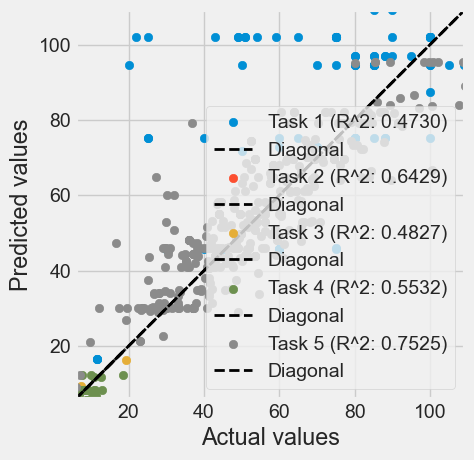

In [16]:
# Start validating
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, save_model_path)

# Calculate predicted values after training
predicted_values = sess.run(Y_test_hat, feed_dict=test_feed_dict)

# Plot actual vs predicted values with R^2 in the legend
for i in range(T):
    X_plot_values = Y_test[i] # 实际值
    Y_plot_values = predicted_values[i] # 预测值
    # Calculate R^2 score for each task
    r2 = r2_score(X_plot_values, Y_plot_values)
    # Plot scatters
    plt.scatter(X_plot_values, Y_plot_values, label=f"Task {i + 1} (R^2: {r2:.4f})")
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    # Calculate axis limits
    min_limit = min(X_plot_values.min(), Y_plot_values.min())
    max_limit = max(X_plot_values.max(), Y_plot_values.max())
    # Plot a diagonal
    plt.plot([min_limit, max_limit], [min_limit, max_limit], 'k--', lw=2, label="Diagonal")
    # Set axis limits and equal aspect ratio
    plt.xlim(min_limit, max_limit)
    plt.ylim(min_limit, max_limit)
    plt.gca().set_aspect('equal', adjustable='box')
    # assert X_plot_values.shape == Y_plot_values.shape
    # for j in range(X_plot_values.shape[0]):
    #     print(f"Task {i} Sample {j}: actual:{X_plot_values[j]},predicted:{Y_plot_values[j]}")
    plt.legend()
    # plt.savefig(save_pic_path + 'task_' + str(i) + '.png')
    # plt.savefig(save_pic_path + 'task_' + str(i) + '_R2=' + str(r2) + '.png')
plt.show()